# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [1]:
import numpy as np
#import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor as pt
import pytensor #inelegant :-(
#import pandas as pd
#import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [3]:
n_samples = 10000

## setup the individual random generators

In [4]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = []
    for lcoefs in coefs:
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem.append({k: (m-avg, s) for k, (m,s) in lcoefs.items()})
    
    return mem

def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients([{i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)])

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in enumerate(contributer_coefficients):
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [5]:
# easy as a start

cc_12 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_22 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_27 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1),
        2: (4, 1)},
    {    0: (3, 1),
        1: (-1, 1),
        2: (-1, 1),
        3: (-1, 1)}
        ]
cc_14 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}]
cc_343 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)},
            {    0: (0, 1),
                1: (0, 1),
                3: (3, 2)}]

In [6]:
print_coefficients(cc_343)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00
Stage 2: Contributer 0 mu=-1.00, sig=1.00
Stage 2: Contributer 1 mu=-1.00, sig=1.00
Stage 2: Contributer 3 mu=2.00, sig=2.00


## Create the Data

In [7]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(contributer_coefficients[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in enumerate(contributer_coefficients):
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [8]:
def run_model(model, **kwargs):
    print("start compilation")
    compiled_model = nutpie.compile_pymc_model(model)
    print("model is compiled")
    trace = nutpie.sample(
        compiled_model,
        **kwargs
        )
    return trace

In [9]:
def analyze(trace):
    az.summary(trace, round_to=2)
    az.plot_trace(trace,
              compact="true",
    chain_prop={"ls": "-"},)

    
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

In [10]:
def generate(n_samples, contributer_coefficients):
    if contributer_coefficients == 2:
        n_contributers= len(contributer_coefficients[1])
        print("ATTENTION: just for one level")
    else:
        n_contributers = [len(level) for level in contributer_coefficients][1:]

    data, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=contributer_coefficients)

    #contributers = contributers.squeeze(-1) # kill the first level - not needed
    return data, contributers, n_contributers

In [11]:
# generate the data
data0, contributers0, n_contributers0 = generate(n_samples=n_samples, contributer_coefficients=cc_14)
data, contributers, n_contributers = generate(n_samples=n_samples, contributer_coefficients=cc_27)

contributers0 = contributers0.squeeze(-1) # for the 1 level version
n_contributers0 = n_contributers0[0]

creating level 0
creating level 1
creating level 0
creating level 1
creating level 2


In [12]:
with pm.Model() as model0:
    """
    simplest model
    converges for 2 contributers almost for more contributers
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    datam = pm.Data("data_idx", data0, dims="obs_id")
    mid = np.mean(data0)

    # Priors
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = mid + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = datam)

In [14]:
n = 5
samples = 10000

In [15]:
def data_faker(n, samples, mu_a=3, sig_a=5, sig_b=1):
    xdata = np.random.normal(mu_a, sig_a, samples)
    bdata = np.random.randint(low=0, high=n, size=(samples))
    mu = np.arange(0, n)-(n-1)/2
    for i,m in enumerate(mu):
        xdata += np.where(bdata == i, np.random.normal(m, sig_b, samples), 0)
    
    return xdata, bdata

In [16]:
xdata, bdata = data_faker(n, samples)

In [19]:
with pm.Model() as model:
    """same as above with different data names"""
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    #baseline
    mu_a = np.mean(xdata)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)
    c = pm.Normal("c", mu=0, sigma=sigma_c, shape=n)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)


start compilation
model is compiled


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,1,0.79,7
,1300,0,0.75,7
,1300,1,0.80,7
,1300,0,0.78,3
,1300,1,0.78,3
,1300,0,0.76,3


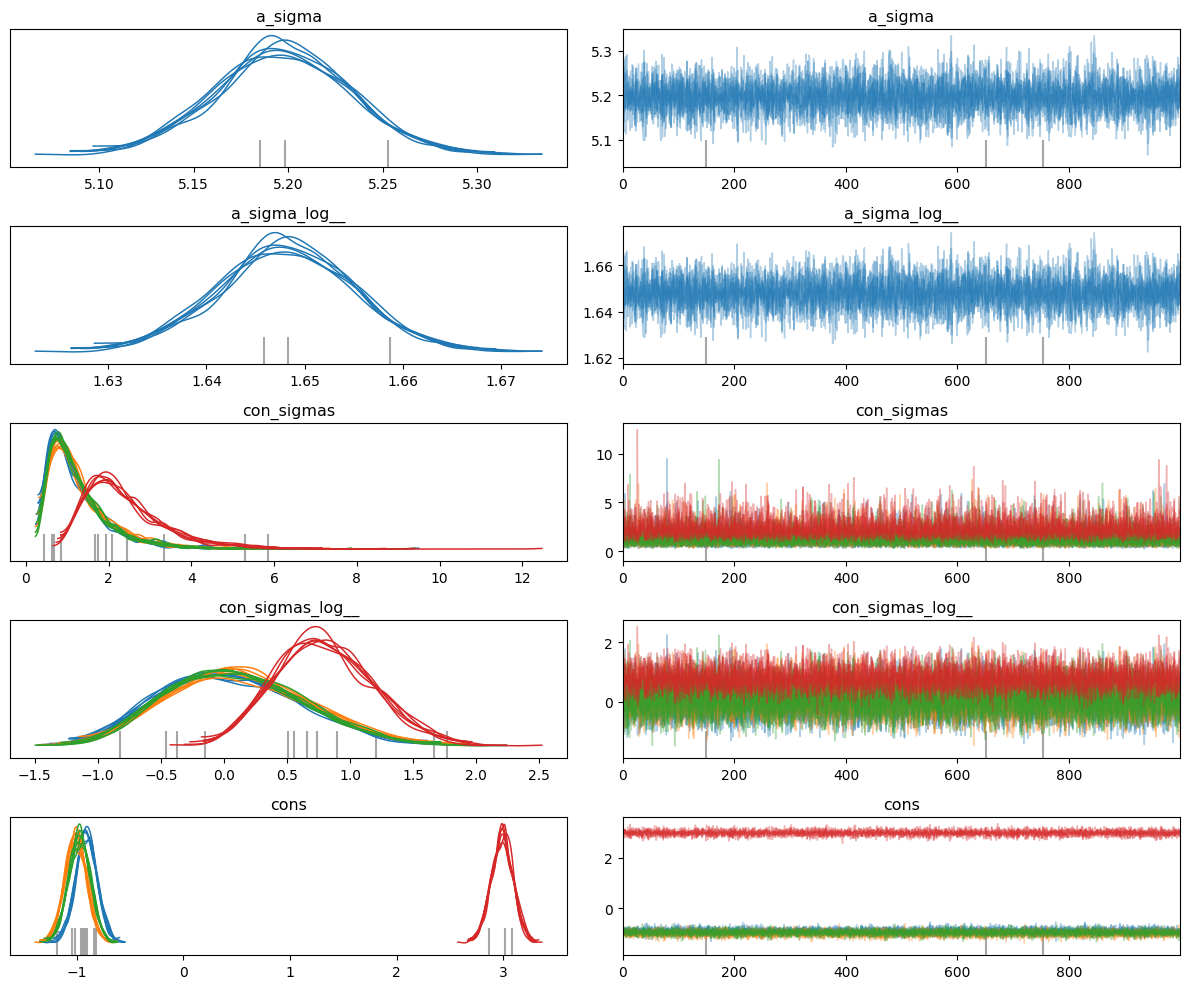

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sigma,5.20,0.04,5.13,5.26,0.00,0.00,8237.82,4784.76,1.0
a_sigma_log__,1.65,0.01,1.63,1.66,0.00,0.00,8237.82,4784.76,1.0
con_sigmas[0],1.24,0.78,0.30,2.65,0.01,0.01,6795.05,4677.80,1.0
con_sigmas[1],1.32,0.82,0.31,2.79,0.01,0.01,7720.83,4476.28,1.0
con_sigmas[2],1.28,0.79,0.34,2.73,0.01,0.01,7524.57,4774.08,1.0
con_sigmas[3],2.39,1.00,0.95,4.26,0.01,0.01,8137.67,4856.46,1.0
con_sigmas_log__[0],0.06,0.55,-0.91,1.12,0.01,0.01,6795.05,4677.80,1.0
con_sigmas_log__[1],0.12,0.55,-0.90,1.13,0.01,0.01,7720.83,4476.28,1.0
con_sigmas_log__[2],0.09,0.54,-0.84,1.14,0.01,0.01,7524.57,4774.08,1.0
con_sigmas_log__[3],0.80,0.39,0.10,1.53,0.00,0.00,8137.67,4856.46,1.0


In [14]:
trace = run_model(model0)
analyze(trace)
az.summary(trace, round_to=2)

# Multi Level Models

In [28]:
n_per_layer = n_contributers
n_level = len(n_per_layer)
xdata = data
bdata = contributers


In [30]:

#with pm.Model(coords={"data"}) as multi_layer_model:
with pm.Model() as multi_layer_model_ref:
    """constrained model with reparametrization and zero sum normal distribution
    adapted to multiple layers"""
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims=("obs_id", "layer"), shape=(n_samples, n_level))
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    sigma_c= [pm.Exponential(f"sigma_c_{level}", 1, shape=n_level) for level, n_level in enumerate(n_per_layer)]
    c_dist = [pm.ZeroSumNormal(f"c_dist_{level}", sigma=1, shape=n_level) for level, n_level in enumerate(n_per_layer)]
    #c = [pm.Deterministic(f"c_{level}", pt.tensor.dot(sigma_c[level], c_dist[level]))  for level in range(n_layers)]


    c = [pm.Deterministic(f"c_{level}", sigma_c[level]* c_dist[level])  for level in range(n_level)]
    
    #y_hat = mu_a + pt.tensor.sum(pt.tensor.concatenate(c, axis=1), axis=1)
    """
    y_hat = mu_a + pt.tensor.sum(
        pt.tensor.concatenate(
            [c_[b[:,i]] for i, c_ in enumerate(c)] # THIS ONE DOES NOT WORK. BUT WHY??
            ),
              axis=1
              )
    """
    y_hat = mu_a + c[0][b[:,0]]+ c[1][b[:,1]] # funktioniert

    """
    c0 = pm.Deterministic(f"c_{0}", sigma_c[0]* c_dist[0])
    c1 = pm.Deterministic(f"c_{1}", sigma_c[1]* c_dist[1]) 
    y_hat = mu_a + c0[b[:,0]]+ c1[b[:,1]]
    # THis one works
    """

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)


#with pm.Model(coords={"data"}) as multi_layer_model:

with pm.Model() as multi_layer_model_simple:
    """constrained model with reparametrization and zero sum normal distribution
    adapted to multiple layers"""
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims=("obs_id", "layer"), shape=(n_samples, n_level))
    
    #baseline
    mu_a = np.mean(xdata)
    sigma_a= pm.Exponential("sigma_a", 1)

    #sigma_c= [pm.Exponential(f"sigma_c_{level}", 1, shape=n_contributers) for level, n_contributers in enumerate(n_per_layer)]
    #c_dist = [pm.ZeroSumNormal(f"c_dist_{level}", sigma=1, shape=n_contributers) for level, n_contributers in enumerate(n_per_layer)]
    #c = [pm.Deterministic(f"c_{level}", pt.tensor.dot(sigma_c[level], c_dist[level]))  for level in range(n_layers)]


    #c = [pm.Deterministic(f"c_{level}", sigma_c[level]* c_dist[level])  for level in range(n_contributers)]
    c = [pm.Normal(f"c_{level}", mu=0, sigma=1, shape=n_contributers) for level, n_contributers in enumerate(n_per_layer)]
    #y_hat = mu_a + pt.tensor.sum(pt.tensor.concatenate(c, axis=1), axis=1)
    """
    y_hat = mu_a + pt.tensor.sum(
        pt.tensor.concatenate(
            [c_[b[:,i]] for i, c_ in enumerate(c)] # THIS ONE DOES NOT WORK. BUT WHY??
            ),
              axis=1
              )
    """
    y_hat = mu_a + c[0][b[:,0]]+ c[1][b[:,1]] # funktioniert
    #y_hat = mu_a + pt.tensor.sum(pt.tensor.concatenate([c[i][b[:,i]] for i in range(n_level)], axis=1))


    """
    c0 = pm.Deterministic(f"c_{0}", sigma_c[0]* c_dist[0])
    c1 = pm.Deterministic(f"c_{1}", sigma_c[1]* c_dist[1]) 
    y_hat = mu_a + c0[b[:,0]]+ c1[b[:,1]]
    # THis one works
    """

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

start compilation
model is compiled


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.49,7
,1300,0,0.49,31
,1300,0,0.41,3
,1300,0,0.43,3
,1300,0,0.41,23
,1300,0,0.42,7


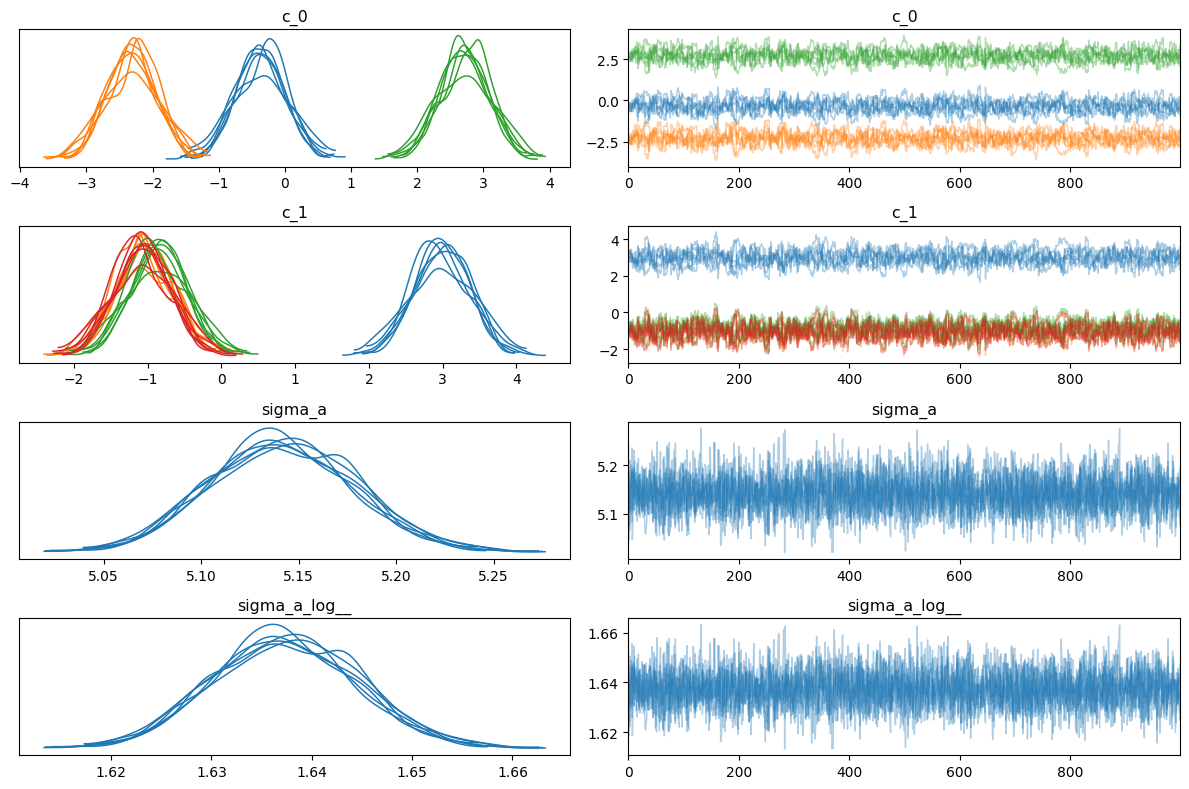

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c_0[0],-0.36,0.39,-1.09,0.39,0.02,0.01,652.47,796.83,1.01
c_0[1],-2.31,0.39,-3.03,-1.55,0.02,0.01,648.75,809.47,1.01
c_0[2],2.72,0.39,1.98,3.46,0.02,0.01,657.25,736.06,1.01
c_1[0],2.99,0.40,2.21,3.71,0.02,0.01,666.36,854.99,1.01
c_1[1],-1.05,0.40,-1.78,-0.30,0.02,0.01,680.24,807.89,1.01
c_1[2],-0.86,0.40,-1.62,-0.12,0.02,0.01,644.06,757.56,1.01
c_1[3],-1.08,0.40,-1.84,-0.35,0.02,0.01,657.00,818.80,1.01
sigma_a,5.14,0.04,5.07,5.21,0.00,0.00,4748.85,4045.08,1.00
sigma_a_log__,1.64,0.01,1.62,1.65,0.00,0.00,4748.85,4045.08,1.00


In [31]:
trace = run_model(multi_layer_model_simple)
analyze(trace)
az.summary(trace, round_to=2)